In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import cv2
import h5py
from tqdm import tqdm_notebook
from keras.preprocessing.image import load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
# ref
# https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

In [4]:
TRAIND = 'data/train/'
TRAIN_IMGS = TRAIND+'images/'
TRAIN_MASKS = TRAIND+'masks/'

In [22]:
# resnet expects 224 => better results with size 224?
size_original = (101, 101)
size_target = (256, 256)

def upsample(img):
    return resize(img, size_target, mode='constant', preserve_range=True)

def downsample(img):
    return resize(img, size_original, mode='constant', preserve_range=True)

# Extraction

In [6]:
train_df = pd.read_csv('data/train.csv', index_col='id', usecols=[0])
depth_df = pd.read_csv('data/depths.csv', index_col='id')
# depth dataframes
train_ddf = train_df.join(depth_df)
test_ddf = depth_df[~depth_df.index.isin(train_ddf.index)]

In [7]:
# images to include in df
imgs = [np.array(load_img(TRAIN_IMGS+img_id+'.png', color_mode = "grayscale")) / 255 \
       for img_id in tqdm_notebook(train_df.index)]

In [8]:
train_ddf['masks'] = [np.array(load_img(TRAIN_MASKS+img_id+'.png', color_mode = "grayscale")) / 255 \
       for img_id in tqdm_notebook(train_df.index)]

In [9]:
train_ddf['imgs'] = imgs
train_ddf['imgs_sum'] = [np.sum(x) for x in imgs]
train_ddf['masks_sum'] = [np.sum(y) for y in train_ddf['masks'].values]

In [10]:
# divide into classes to ensure val/train is valid
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_ddf['coverage'] = train_ddf.masks.map(np.sum) / (3 * pow(np.sum(size_original), 2))        
train_ddf['coverage_class'] = train_ddf.coverage.map(cov_to_class)

In [11]:
# new data set for training the identifier 
train_ddf['salt'] = np.where(train_ddf['masks_sum']>0, 1, 0)

In [11]:
train_ddf[['salt']].to_csv('salt-identifier.csv')

# Cleaning

In [11]:
# # Remove 80 blank images
# train_ddf = train_ddf[train_ddf.imgs_sum > 0]
# len(train_ddf)

In [12]:
# use easy images for first model of transfer learning
# e = (101*101) * 0.01
# train_ddf = train_ddf[(train_ddf.masks_sum > e) | (train_ddf.masks_sum == 0)]
# len(train_ddf)

# Resize

In [12]:
x_train = np.array(train_ddf.imgs.map(upsample).tolist()).reshape(-1, size_target[0], size_target[1], 1)
y_train = np.array(train_ddf.masks.map(upsample).tolist()).reshape(-1, size_target[0], size_target[1], 1)

/Users/brennangebotys/miniconda3/envs/playground/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


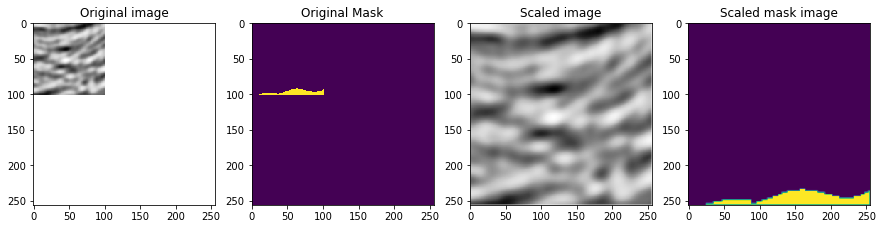

In [11]:
# sanity check
i = 4
tmp_img = np.zeros(size_target, dtype=np.float32)
tmp_mask = np.zeros(size_target, dtype=np.float32)
tmp_img[:size_original[0], :size_original[1]] = train_ddf.imgs.loc[train_ddf.index[i]]
tmp_mask[:size_original[0], :size_original[1]] = train_ddf.masks.loc[train_ddf.index[i]]

fix, axs = plt.subplots(1, 4, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(tmp_mask)
axs[1].set_title("Original Mask")

axs[2].imshow(x_train[i].squeeze(), cmap="Greys")
axs[2].set_title("Scaled image")
axs[3].imshow(y_train[i].squeeze())
axs[3].set_title("Scaled mask image")
plt.show()

# Split & Save

In [18]:
xtrain, xval, ytrain, yval, \
dtrain, dval, idtrain, idval = train_test_split(x_train, y_train, \
                                                train_ddf.z.values, [a.encode('utf8') for a in train_ddf.index.values], \
                                                stratify=train_ddf.coverage_class, test_size=0.1)

In [17]:
# path = 'tfmodel/'
path = '../data/processed-data/'

In [1]:
# data = [xtrain, xval, ytrain, yval, dtrain, dval, idtrain, idval]
# names = ['xtrain', 'xval', 'ytrain', 'yval', 'dtrain', 'dval', 'idtrain', 'idval']

# for d, n in zip(data, names): 
#     with h5py.File(path+'{}.h5'.format(n), 'w') as hf:
#         hf.create_dataset(n, data=d)

In [13]:
import numpy as np
import tensorflow as tf

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from helpers import TrainValTensorBoard, get_data, createGenerator
from losses import dice_loss, bce_dice_loss, bce_logdice_loss

import sys
sys.path.insert(0, 'unet/')
from model import unet
%load_ext autoreload
%autoreload 2

In [14]:
H, W, C = 256, 256, 1

BATCH_SIZE = 64
EPOCHS = 100

learning_rate = 1e-2

filter_sizes = [32, 64, 128, 256]
bn_fsize = 64
loss = dice_loss

model = unet((H, W, C), filter_sizes, bn_fsize, learning_rate, loss)
model.load_weights('unet/model_weights.hdf5')

In [23]:
preds_valid = model.predict([xval, dval]).reshape(-1, H, W)

In [28]:
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_ddf.loc[idx].masks for idx in np.array(idval).astype(str)])

/Users/brennangebotys/miniconda3/envs/playground/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

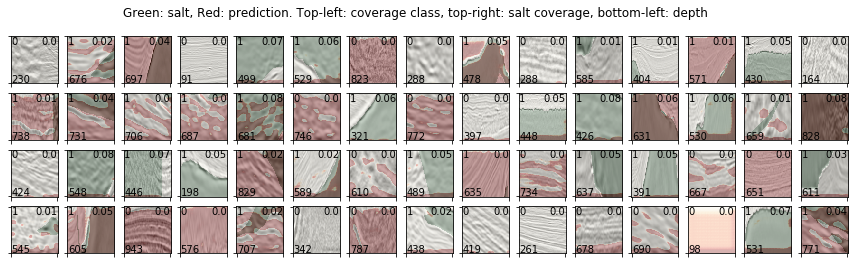

In [32]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(np.array(idval).astype(str)[:max_images]):
    img = train_ddf.loc[idx].imgs
    mask = train_ddf.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, 101-1, train_ddf.loc[idx].z, color="black")
    ax.text(101 - 1, 1, round(train_ddf.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_ddf.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [33]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [34]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [35]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

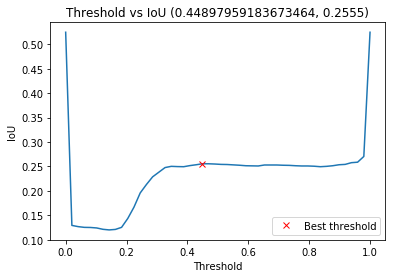

In [36]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [37]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [41]:
x_test = np.array([upsample(np.array(load_img("data/test/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_ddf.index)]).reshape(-1, 256, 256, 1)

/Users/brennangebotys/miniconda3/envs/playground/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/Users/brennangebotys/miniconda3/envs/playground/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [44]:
preds_test = model.predict([x_test, test_ddf.z.values])

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')